In [1]:
import network_manipulation as nm
import network_stats as ns
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import networkx as nx

dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

Node measures
degree : 23.734491315136477
weight : 14.691270256142184
closeness : 207.61231638343395
betweenness : 0.9577672733588912
eigenvector : 17.156434026362536


Network measures
nodes : 403
edges : 9565
ratio : 23.734491315136477
components : 1
density : 0.11808204634396256
path : 1.9530140858980531
diameter : 4
transitivity : 0.23590263303822398




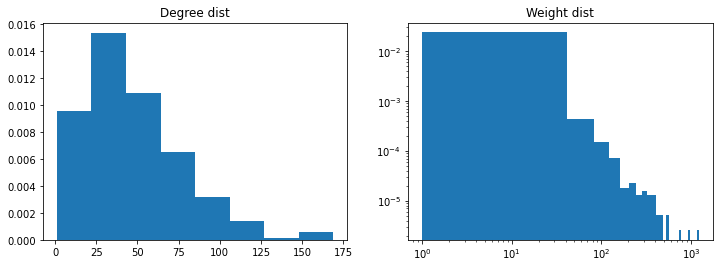

In [2]:
# Measuring original network

G = nm.build_nxgraph(dataset_paths[0], False) 
node_measures = ns.measure_nodes(G)
network_measures = ns.measure_network(G)

def print_dict(dict):
    for key in list(dict.keys()):
        print(key + ' : ' + str(dict[key]))
    print('\n')
        
print('Node measures')
print_dict(node_measures)
print('Network measures')
print_dict(network_measures)

degrees, weights = ns.analyse_graph(G)

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

axis[0].hist(degrees, bins = 8, density = 1)
axis[0].set_title('Degree dist')

axis[1].hist(weights, bins = 30, density = 1)
axis[1].set_title('Weight dist')
axis[1].set_xscale('log')
axis[1].set_yscale('log')
plt.show()

# Should also include plots of degree dist and weight dist

In [3]:
G['1467']['1591']['weight']

17

In [5]:
# For some reason this breaks when using normalizaed weights
# While logbinning the data, it complains about ydata not being defined
# This could be because the scale is designed to be calculated for un-normalized
# weights, so could fix by making log binning function account for norming

import scipy.stats as sps

dfit, dcov = ns.fit_degrees(degrees)

class degree_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.degree_func(x, *dfit)

ddist = degree_distribution(a=0)
degree_samples = ddist.rvs(size = 500) # 1000 samples, 2.5x bigger for network[0]
degree_samples = np.ceil(degree_samples).astype(int)
degree_samples = [ds for ds in degree_samples if ds != 0] # removes any zeros

print(sum(degree_samples))
if sum(degree_samples)%2 != 0:
    degree_samples = np.append(degree_samples, 35) # chose this as seems to be average from graph
print(sum(degree_samples))

H = nx.configuration_model(degree_samples, create_using = nx.Graph)
scale, scale_err = ns.optimize_scale(weights)
wfit, wcov = ns.fit_weights(weights, scale)

class weight_distribution(sps.rv_continuous): 
    def _pdf(self, x):
        return ns.weight_func(x, *wfit)

w_func = weight_distribution(a=1)

H = ns.set_weights(H, w_func)

24000
24000
  best scaling factor    best average error
---------------------  --------------------
                 2.81                  1.56


In [ ]:
type(degree_samples)

list

In [ ]:
test = ns.sample_weights(10, wfit)
print(test)

[47.14566807 52.24865241 20.73153204 68.39952877 48.21362236 25.69307154
 24.04394082 20.02721444 58.95848553 42.53690243]


Node measures
degree : 22.208502024291498
weight : 3.9952602315194605
closeness : 248.29362651160102
betweenness : 1.003471363314039
eigenvector : 19.177676514982195


Network measures
nodes : 494
edges : 10971
ratio : 22.208502024291498
components : 1
density : 0.09009534289773427
path : 1.9994087262156015
diameter : 4
transitivity : 0.1556479931866821




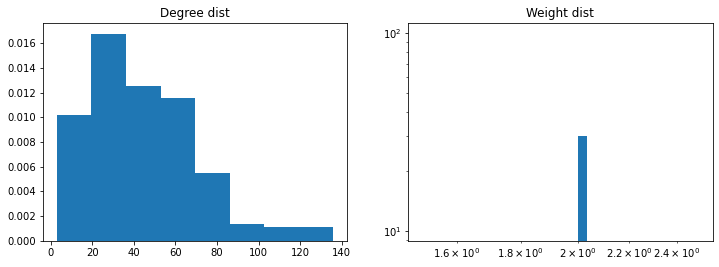

In [6]:
node_measures = ns.measure_nodes(H)
network_measures = ns.measure_network(H)

print('Node measures')
print_dict(node_measures)
print('Network measures')
print_dict(network_measures)

gen_degrees, gen_weights = ns.analyse_graph(H) # changed variable name to stop throwing off optimize_scale function

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)

axis[0].hist(gen_degrees, bins = 8, density = 1)
axis[0].set_title('Degree dist')

axis[1].hist(gen_weights, bins = 30, density = 1)
axis[1].set_title('Weight dist')
axis[1].set_xscale('log')
axis[1].set_yscale('log')
plt.show()

In [ ]:
# Shows that extra components of generated graph are singular nodes (i don't know
# this is happening in the configuration model), the number of extra components
# is equal to the number of times "what the dog doin is printed" which occurs when
# the graph has nodes with no connections, meaning the degree distribution is
# generating 0's so simply need to remove these.

components = list(nx.connected_components(H))
for component in components:
    print(len(component))


493


0
1
2
3
4


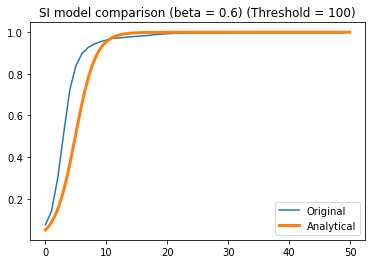

0
1
2
3
4


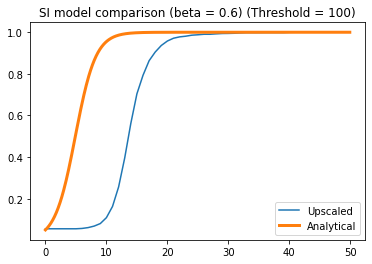

In [7]:
import SI_model_nx as si

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.6
simulation_params['Runs'] = 5
simulation_params['Threshold'] = 100
simulation_params['Increment'] = 0.1

si.SI_comparison(G, simulation_params, 'Original')
si.SI_comparison(H, simulation_params, 'Upscaled')